# Creating Customer Segments

In this project you, will analyze a dataset containing annual spending amounts for internal structure, to understand the variation in the different types of customers that a wholesale distributor interacts with.

Instructions:

- Run each code block below by pressing **Shift+Enter**, making sure to implement any steps marked with a TODO.
- Answer each question in the space provided by editing the blocks labeled "Answer:".
- When you are done, submit the completed notebook (.ipynb) with all code blocks executed, as well as a .pdf version (File > Download as).

In [19]:
# Import libraries: NumPy, pandas, matplotlib
import numpy as np
import pandas as pd
from IPython.core.display import HTML
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
import pylab

# Tell iPython to include plots inline in the notebook
%matplotlib inline

# Read dataset
data = pd.read_csv("wholesale-customers.csv")
print("Dataset has {} rows, {} columns".format(*data.shape))
print(data.head())  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


## Feature Transformation

**1)** In this section you will be using PCA and ICA to start to understand the structure of the data. Before doing any computations, what do you think will show up in your computations? List one or two ideas for what might show up as the first PCA dimensions, or what type of vectors will show up as ICA dimensions.

Answer: Since PCA is going to look to create features that maximize variance, we should see it identify common patterns for different purchaser profiles. ICA on the other hand is looking for statistically unrelated sources and so will likely identify something like the underlying store type (corner store vs. full grocery vs. deli).

### PCA

In [2]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Scale the data using Normalization
scaled = normalize(data, axis=1)

# Build and run the PCA analysis with the number of components set to the original number 
# of features as requested. 
pca = PCA(n_components=data.shape[1])
pca.fit_transform(scaled)

# Print the components and the amount of variance in the data contained in each dimension
dispDF = pd.DataFrame(pca.components_)
dispDF.columns = data.columns
dispDF = dispDF.reset_index()
dispDF['Expl_Variance'] = pca.explained_variance_ratio_
dispDF['Cum_Variance'] = dispDF['Expl_Variance'].cumsum()

dispDF = dispDF.T
dispDF.columns = ["P.C. {}".format(r) for r in range(1,7,1)]
dispDF.drop(['index'], axis=0, inplace=True)
dispDF

,P.C. 1,P.C. 2,P.C. 3,P.C. 4,P.C. 5,P.C. 6
Fresh,-0.720606,0.325226,-0.066263,0.253652,-0.545133,-0.095159
Milk,0.344109,-0.057227,-0.853474,0.043070,-0.330984,-0.196193
Grocery,0.537571,0.220449,0.405897,0.589184,-0.314658,-0.226980
Frozen,-0.106800,-0.898543,0.183398,0.077656,-0.365427,-0.089507
Detergents_Paper,0.247658,0.167915,0.206943,-0.611852,-0.600605,0.364081
Delicatessen,0.024347,-0.082343,-0.161182,0.454174,-0.002605,0.871990
Expl_Variance,0.681885,0.146152,0.096222,0.033272,0.021943,0.020526
Cum_Variance,0.681885,0.828037,0.924259,0.957531,0.979474,1.000000


**2)** How quickly does the variance drop off by dimension? If you were to use PCA on this dataset, how many dimensions would you choose for your analysis? Why?

Answer: 
By the third principal component, we have almost 93% of the variance explained and by the fourth, 96%. I'd probably stop at the fourth to reduce the chances of overfitting in an eventual model and to keep it simpler unless there were other factors needed.

**3)** What do the dimensions seem to represent? How can you use this information?


Answer: The dimensions appear to show relationships between what is frequently purchased together. This information could be used in clustering order types potentially.

The first component has a correlation between Groceries, Milk amd Detergents & Paper with a strong negative relationship with Fresh Produce. This could be showing the overall demand for less-perishable foods. 

The second correlates with an increase in Detergents and Paper and then with Frozen products and is negtively related with the other categories to various levels. This might represent bulk purchases for end-customers since frozen items and sundries tend to be sold in bulk.

The third component is strongly related to the Deli products and then the Frozen and Milk and strongly negatively with Fresh produce purchases. This could point to orders from convinience stores and gas stations where the majority of the product is non-perishable or delicatessen in nature.

### ICA

In [21]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
scaled = preprocessing.scale(scaled)
ica = FastICA(n_components=data.shape[1])
ica.fit_transform(scaled)

# Print the independent components
icaDf = pd.DataFrame(ica.components_)
icaDf.columns = data.columns
icaDf = icaDf.T
icaDf.columns = dispDF.columns = ["I.C. {}".format(r) for r in range(1,7,1)]
icaDf

,I.C. 1,I.C. 2,I.C. 3,I.C. 4,I.C. 5,I.C. 6
Fresh,0.029074,0.018005,0.011175,-0.019674,0.104880,0.048382
Milk,-0.043561,-0.006573,0.005563,-0.014983,0.050258,0.020934
Grocery,0.047442,-0.020833,-0.052257,-0.016915,0.066594,0.022251
Frozen,0.008355,-0.003183,0.008353,-0.010641,0.049515,-0.032534
Detergents_Paper,0.016666,-0.009050,0.071434,0.000045,0.017213,0.006323
Delicatessen,0.009656,0.000088,0.006117,0.049597,0.003223,0.003054


**4)** For each vector in the ICA decomposition, write a sentence or two explaining what sort of object or property it corresponds to. What could these components be used for?

Answer: The independant components could represent the type of store represented by each order group:

1. IC 1 is focused on Groceries, Fresh and Detergents and Paper products. 

2. IC 2 is focused on Groceries and Fresh food.

3. IC 3 is focused on Sundries and Groceries.

4. IC 4 is focused on Deli products and then equally weighted between Fresh, Milk and Grocery.

5. IC 5 is a mix of focuses with a strong relationship with Fresh products and then Grocery, Milk and Frozen products.

6. IC 6 is centered on Fresh, Frozen, Milk and Grocery.

## Clustering

In this section you will choose either K Means clustering or Gaussian Mixed Models clustering, which implements expectation-maximization. Then you will sample elements from the clusters to understand their significance.

### Choose a Cluster Type

**5)** What are the advantages of using K Means clustering or Gaussian Mixture Models?

Answer: K-Means uses hard assignment of points to a cluster (each point completely belongs to the nearest cluster). GMM works with a soft assignment where each point has a probability of being in each cluster computed (no point has 100% membership in any cluster) but the cluster with the highest probability is considered the cluster for that point.

K-Means is a bit less intense since it only involves a simple distance metric vs. the two phase expectation/maximization steps but GMM should give us a cleaner decision boundary since it takes the probability of edge cases into account. Since the expectation/maximization phases are somewhat more involved this adds a time/computation penalty to choosing GMM but since the dataset is small, the calculation cost is negligable.  

**6)** Below is some starter code to help you visualize some cluster data. The visualization is based on [this demo](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html) from the sklearn documentation.

In [3]:
# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

In [41]:
# TODO: First we reduce the data to two dimensions using PCA to capture variation
scaled = normalize(data, axis=1)
pcaR = PCA(n_components=2, whiten=True)
reduced_data = pcaR.fit_transform(scaled)
print reduced_data[:10]  # print upto 10 elements

[[ 0.0747855   0.85626056]
 [ 0.77133586  0.22136883]
 [ 0.67096448 -0.26364006]
 [-0.84300783 -0.76783622]
 [-0.70000196  0.36529226]
 [ 0.08205991  0.56880451]
 [-0.26404871  1.1545639 ]
 [ 0.5268229   0.4942843 ]
 [ 0.36407001  0.89197461]
 [ 1.24993939  0.51819535]]


Vidualizing with 2 customer clusters:


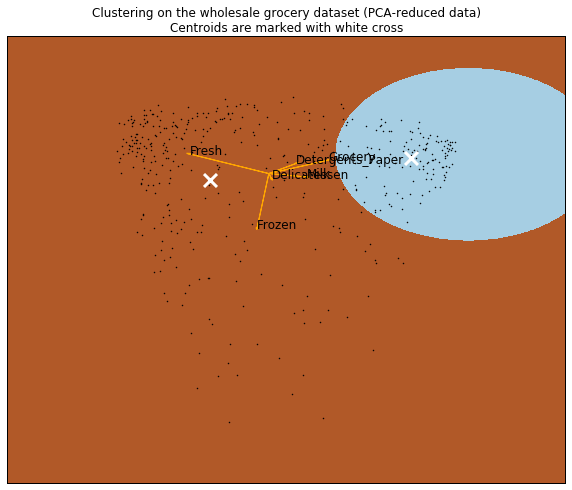

Cluster Mean Descriptions:


,Cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,4074,10566,15998,1214,7125,1369
1,1,15324,3796,4577,3851,1102,1590



Vidualizing with 3 customer clusters:


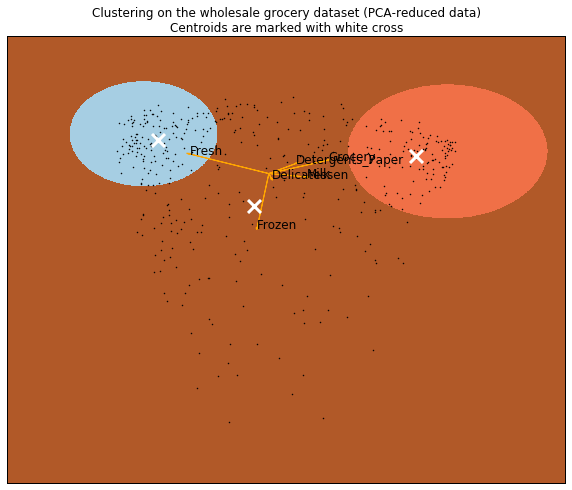

Cluster Mean Descriptions:


,Cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,21004,2496,3134,2388,584,1224
1,1,3996,10927,16798,1182,7611,1370
2,2,10495,4954,5861,4771,1560,1844



Vidualizing with 4 customer clusters:


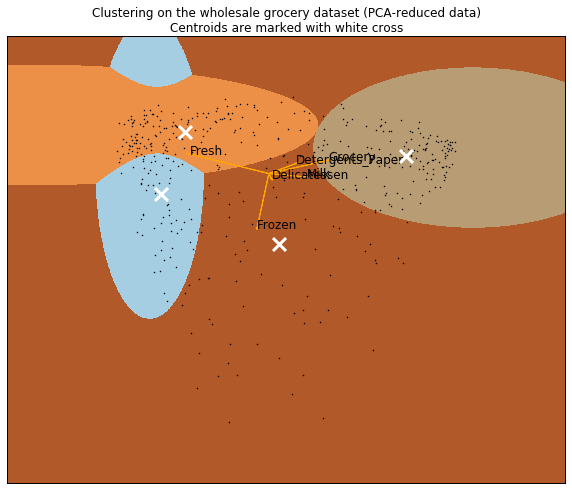

Cluster Mean Descriptions:


,Cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,15991,2408,2622,6052,442,1144
1,1,4477,10322,15605,1225,6918,1453
2,2,20113,3470,4806,1815,1155,1359
3,3,6708,5076,4975,6154,1145,2247



Vidualizing with 5 customer clusters:


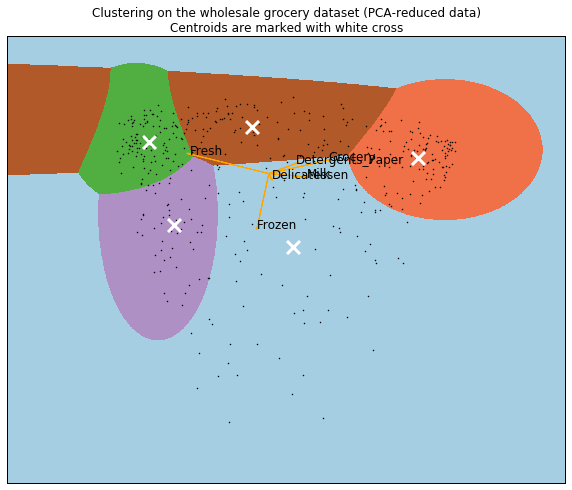

Cluster Mean Descriptions:


,Cluster,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicatessen
0,0,5857,5424,4803,6132,906,2489
1,1,22890,2266,2959,2646,507,1193
2,2,3372,10317,16095,1107,7304,1320
3,3,14191,2795,2748,6938,484,1187
4,4,13814,6358,9282,1225,3148,1577


In [48]:
# TODO: Implement your clustering algorithm here, and fit it to the reduced data for visualization
# The visualizer below assumes your clustering object is named 'clusters'

def plotClusters(n):
    print('Vidualizing with {0:0} customer clusters:'.format(n))
    
    mod = GMM(n_components=n)
    mod.fit(reduced_data)
    clusters = mod
    
    rdCopy = data
    rdCopy['Cluster'] = clusters.predict(reduced_data)
    
    # Plot the decision boundary by building a mesh grid to populate a graph.
    x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
    y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
    hx = (x_max-x_min)/2000.
    hy = (y_max-y_min)/2000.
    xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

    # Obtain labels for each point in mesh. Use last trained model.
    Z = clusters.predict(np.c_[xx.ravel(), yy.ravel()])

    # Find the centroids for KMeans or the cluster means for GMM 
    centroids = mod.means_

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(10, 8))
    plt.clf()
    plt.imshow(Z, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    for i, (pc1, pc2) in enumerate(zip(pca.components_[0], pca.components_[1])):
        plt.arrow(0, 0, pc1, pc2, width=0.001, fc='orange', ec='orange')
        plt.annotate(data.columns[i], (pc1, pc2), size=12)
    plt.xticks(())
    plt.yticks(())
    plt.show()
    print('Cluster Mean Descriptions:')
    display(np.round(rdCopy.groupby(['Cluster']).mean().reset_index()))
    print 
    
for n in range(2,6):
    plotClusters(n)

**7)** What are the central objects in each cluster? Describe them as customers.

Answer: Plotting the raw data provides for very clustered data so I elected to use normalize which provides a more distributed visualization and more interpretable clusters. When choosing the optimum number of clusters, I am choosing to use the 4 cluster option since it captures both the high and low range of our two principal components and higher numbers of clusters tend to become overly specific for our use.

Looking at both the overlaid PCA vector lines and the means for the samples in each category we can describe our cluster groups. The first cluster is heavily centered on Fresh produce with some Frozen and much less of the rest. This to me can be interpreted as a medium sized fresh-grocers.

The second cluster is a more frequent purchaser of Groceries, Dairy and Detergent products and moderate fresh produce. This group may represent big-box format stores which sell a lot of less perishable goods in quantity with loss leading dairy (Costco or WalMart etc.) with less emphasis on fresh produce since it is typically very perishable and fewer end consumers would purchase in quantity.

The third group purchases mostly fresh produce with limited amounts of Grocery and Milk and very little of the other groups. This to me would be market vendors and other groups that sell large volumes of produce with very little movement in other categories.

Our last group visually acts as a bit of a catch-all for the rest with a more even distribution between Fresh, Milk, Grocery and Frozen products. While the mean sales are smaller they are also the leading cluster for Deli products as well. These might represent small corner stores or other places that sell limited amounts of foods with an emphasis on immediate consumption and convenience.


### Conclusions

** 8)** Which of these techniques did you feel gave you the most insight into the data?

Answer: I felt that PCA provided a more useful resulting feature set in the context of trying to identify buying patterns (especially when comparing a plot of PCA based clusters with a biplot of the PCA components.) Depending on the end goal of the segmentation project, ICA or other methods could have been more useful.

**9)** How would you use that technique to help the company design new experiments?

Answer: I'd try to engineer the tests to ensure both samples draw evenly from each cluster of customers to ensure they are appropriately balanced. By keeping both test and control groups from both clusters we can make sure we measure what effect the experiment change has on both clusters of customers. If only one shows a positive change, we can make sure to limit production deployments to that group.

The first experiment I would propose would be to see if offering more frequent, slightly smaller produce deliveries to a sample of customers in Clusters 1 and 4 increases their produce demand overall while reducing wastage since there would in theory be a faster turnover of produce with less spoilage. If we saw an overall increase in purchasing compared to a control group with the regular delivery schedules, that would be indicative of a successful strategy change.

**10)** How would you use that data to help you predict future customer needs?

Answer: By understanding the buying motives and needs of our customers, we can tailor the selling and relationship management processes to the most appropriate model for that type of customer. This makes for a better customer relationship since we can work to anticipate their needs and possibly stock new products that would appeal to them or run promotions that would compliment their businesses. Some immediate thoughts about the clusters:

**a)** Clusters 1 and 4 tend to have very large volumes of produce and may be willing to order more frequently or pay a delivery premium for more frequent shipping to ensure peak produce condition

**b)** The fourth cluster stands out in it's increased purchases of Deli products and could be targeted with new convenience foods.

